# Predict Reviews in the Notebook 

In [1]:
!pip install -q pip --upgrade
!pip install -q wrapt --upgrade --ignore-installed
!pip install -q tensorflow==2.1.0 --upgrade --ignore-installed
!pip install -q transformers==2.8.0

ERROR: astroid 2.3.3 has requirement wrapt==1.11.*, but you'll have wrapt 1.12.1 which is incompatible.
ERROR: spyder 4.1.2 requires pyqt5<5.13; python_version >= "3", which is not installed.
ERROR: spyder 4.1.2 requires pyqtwebengine<5.13; python_version >= "3", which is not installed.
ERROR: pytest-astropy 0.8.0 requires pytest-cov>=2.0, which is not installed.
ERROR: pytest-astropy 0.8.0 requires pytest-filter-subpackage>=0.1, which is not installed.
ERROR: jupyterlab 1.2.6 has requirement jupyterlab_server~=1.0.0, but you'll have jupyterlab-server 1.1.0 which is incompatible.
ERROR: awswrangler 1.2.0 has requirement numpy~=1.18.0, but you'll have numpy 1.19.1 which is incompatible.
ERROR: awscli 1.18.93 has requirement rsa<=3.5.0,>=3.1.2, but you'll have rsa 4.6 which is incompatible.
ERROR: astroid 2.3.3 has requirement wrapt==1.11.*, but you'll have wrapt 1.12.1 which is incompatible.


In [2]:
import boto3
import sagemaker
import pandas as pd

sess   = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name='sagemaker', region_name=region)

# Retrieve the Training Job Name

In [3]:
%store -r training_job_name

In [4]:
print('Previous training_job_name: {}'.format(training_job_name))

Previous training_job_name: tensorflow-training-2020-07-25-18-45-23-722


# Download the Trained Model

In [5]:
models_dir = './models'

In [6]:
# Download the model and output artifacts from AWS S3
!aws s3 cp s3://$bucket/$training_job_name/output/model.tar.gz $models_dir/model.tar.gz

download: s3://sagemaker-us-west-2-140773038493/tensorflow-training-2020-07-25-18-45-23-722/output/model.tar.gz to models/model.tar.gz


In [7]:
import tarfile
import pickle as pkl

#!ls -al ./models

tar = tarfile.open('{}/model.tar.gz'.format(models_dir))
tar.extractall(path=models_dir)
tar.close()

In [8]:
!ls -al $models_dir

total 487096
drwxrwxr-x  6 ec2-user ec2-user      4096 Jul 25 18:57 .
drwxrwxr-x 11 ec2-user ec2-user      4096 Jul 25 18:57 ..
drwxr-xr-x  2 ec2-user ec2-user      4096 Jul 25 18:53 metrics
-rw-rw-r--  1 ec2-user ec2-user 498757018 Jul 25 18:54 model.tar.gz
drwxr-xr-x  2 ec2-user ec2-user      4096 Jul 25 18:48 tensorboard
drwxr-xr-x  3 ec2-user ec2-user      4096 Jul 25 18:48 tensorflow
drwxr-xr-x  3 ec2-user ec2-user      4096 Jul 25 18:48 transformers


# Load the Model

In [9]:
transformer_model_dir = '{}/transformers/fine-tuned/'.format(models_dir)

!ls -al $transformer_model_dir

total 261692
drwxr-xr-x 2 ec2-user ec2-user      4096 Jul 25 18:52 .
drwxr-xr-x 3 ec2-user ec2-user      4096 Jul 25 18:48 ..
-rw-r--r-- 1 ec2-user ec2-user      1358 Jul 25 18:52 config.json
-rw-r--r-- 1 ec2-user ec2-user 267959068 Jul 25 18:52 tf_model.h5


In [10]:
cat $transformer_model_dir/config.json

{
  "_num_labels": 5,
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "bad_words_ids": null,
  "bos_token_id": null,
  "decoder_start_token_id": null,
  "dim": 768,
  "do_sample": false,
  "dropout": 0.1,
  "early_stopping": false,
  "eos_token_id": null,
  "finetuning_task": null,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "is_decoder": false,
  "is_encoder_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 512,
  "min_length": 0,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "no_repeat_ngram_size": 0,
  "num_beams": 1,
  "num_return_sequences": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true

In [11]:
import os
from transformers import TFDistilBertForSequenceClassification

loaded_model = TFDistilBertForSequenceClassification.from_pretrained(transformer_model_dir,
                                                                     id2label={
                                                                       0: 1,
                                                                       1: 2,
                                                                       2: 3,
                                                                       3: 4,
                                                                       4: 5
                                                                     },
                                                                     label2id={
                                                                       1: 0,
                                                                       2: 1,
                                                                       3: 2,
                                                                       4: 3,
                                                                       5: 4
                                                                     })

In [12]:
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

inference_device = -1 # CPU: -1, GPU: 0
print('inference_device {}'.format(inference_device))

inference_device -1


In [13]:
from transformers import TextClassificationPipeline

inference_pipeline = TextClassificationPipeline(model=loaded_model, 
                                                tokenizer=tokenizer,
                                                framework='tf',
                                                device=inference_device) # -1 is CPU, >= 0 is GPU

In [14]:
review = """I loved it!"""
print(review, inference_pipeline(review))

I loved it! [{'label': 5, 'score': 0.2530081}]


In [15]:
review = """Not that good."""
print(review, inference_pipeline(review))

Not that good. [{'label': 5, 'score': 0.25903675}]


# Test Model

In [16]:
import csv

df_test_reviews = pd.read_csv('./data/amazon_reviews_us_Digital_Software_v1_00.tsv.gz', 
                                delimiter='\t', 
                                quoting=csv.QUOTE_NONE,
                                compression='gzip')[['review_body', 'star_rating']]

df_test_reviews = df_test_reviews.sample(n=100)

df_test_reviews.shape

(100, 2)

In [17]:
df_test_reviews.head()

,review_body,star_rating
40766,Has made keeping track of all business transac...,5
93231,I have not been able to access this Microsoft ...,1
3956,"It's working, no virus so far, worth the money.",4
100796,I used Webroot for several years prior to this...,5
99724,"works ok, but too many times it doesnt really ...",3


In [18]:
import pandas as pd

def predict(review_body):
    prediction_map = inference_pipeline(review_body)
    return prediction_map[0]['label']
    
y_test = df_test_reviews['review_body'].map(predict)

y_test

40766     5
93231     5
3956      5
100796    5
99724     5
         ..
27056     5
49339     5
45350     5
14802     5
76640     5
Name: review_body, Length: 100, dtype: int64

In [19]:
y_actual = df_test_reviews['star_rating']

y_actual

40766     5
93231     1
3956      4
100796    5
99724     3
         ..
27056     4
49339     4
45350     3
14802     5
76640     4
Name: star_rating, Length: 100, dtype: int64

# Classification Report

In [20]:
from sklearn.metrics import classification_report

print(classification_report(y_true=y_test, y_pred=y_actual))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       1.00      0.43      0.60       100

    accuracy                           0.43       100
   macro avg       0.20      0.09      0.12       100
weighted avg       1.00      0.43      0.60       100



/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Accuracy

In [21]:
from sklearn.metrics import accuracy_score

print('Accuracy: ', accuracy_score(y_true=y_test, y_pred=y_actual))

Accuracy:  0.43


# Confusion Matrix

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_conf_mat(cm, classes, title, cmap = plt.cm.Greens):
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment="center",
        color="black" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [21  5  9 22 43]]


<Figure size 432x288 with 0 Axes>

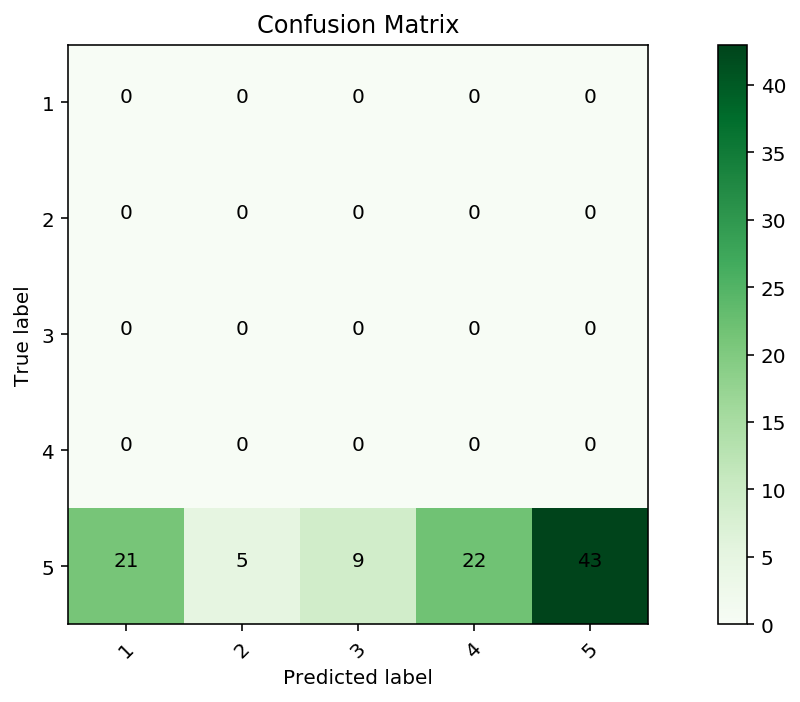

In [23]:
import itertools
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

cm = confusion_matrix(y_true=y_test, y_pred=y_actual)

plt.figure()
fig, ax = plt.subplots(figsize=(10,5))
plot_conf_mat(cm, 
              classes=['1', '2', '3', '4', '5'], 
              title='Confusion Matrix')
plt.show()

In [ ]:
%%javascript
Jupyter.notebook.save_checkpoint();
Jupyter.notebook.session.delete();